# Capstone Project Code

## Load Packages

In [25]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import os
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl
import tensorflow as tf
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings("ignore")
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Initial Exploration
- Load Data
- Explore Data Pattern
- Explore Missing Values


### Load Data

In [26]:
A01_17= pd.read_hdf('/content/drive/MyDrive/pressure_data/A01_CMPR_COMPRESSOR_SUPPLY_PRESSURE_20161231_366days.hdf')

In [27]:
W01 = pd.read_hdf('/content/drive/MyDrive/weather/WeatherStationController_MeteoCentral_TEMPERATURE_20161231_366days.hdf')

### Explore Data Pattern

In [28]:
def decompose_date_time(df):
  df['day'] = df['Date'].dt.day
  df['month'] = df['Date'].dt.month
  df['year'] = df['Date'].dt.year
  df['hour'] = df['Date'].dt.hour
  df['minute'] = df['Date'].dt.minute
  df['second'] = df['Date'].dt.second

In [29]:
ABS_PATH = '/content/drive/MyDrive/'

def read_and_merge_data(data_type):
  '''
  read_and_merge_data('weather') returns a dictionary that maps
    location to the weather data with columns 'Date' and 'Data'

  read_and_merge_data('pressure_data') returns a dictionary that maps
    location to the pressure data with columns 'Date' and 'Data'
  '''
  path = ABS_PATH + data_type
  os.chdir(path)
  filenames = os.listdir()
  filenames.sort()
  data_ret = {}
  # collect data of the same lcoation
  for i in range(len(filenames)//3):
    curr_files = filenames[i*3:i*3+3]
    if data_type == "weather":
      curr_loc = curr_files[0].split('_')[1]
    else:
      curr_loc = curr_files[0].split('_')[0]

    dfs = []
    for file in curr_files:
      file_path = f"{path}/{file}"
      df = pd.read_hdf(file_path)
      df.reset_index(inplace = True)
      mapping = {df.columns[0]:'Date', df.columns[1]: 'Data'}
      df = df.rename(columns=mapping)
      decompose_date_time(df)
      dfs.append(df)
    data_ret[curr_loc] = pd.concat(dfs)
  return data_ret

In [30]:
weather_data = read_and_merge_data("weather")
pressure_data = read_and_merge_data("pressure_data")

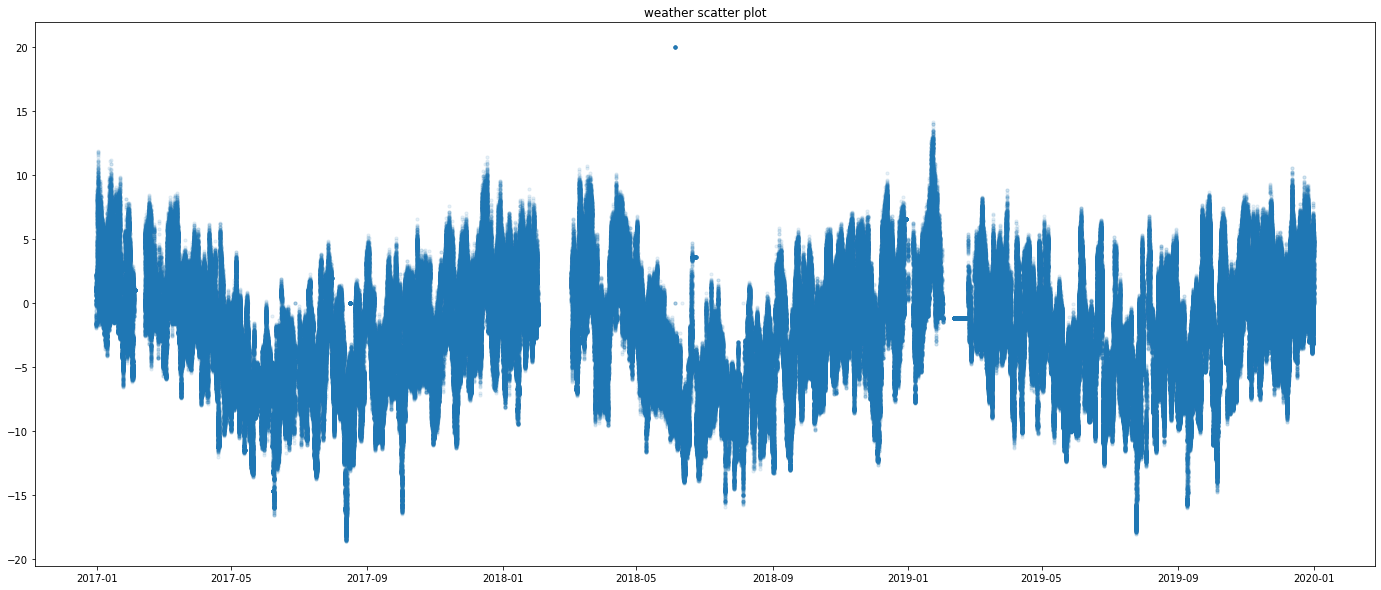

In [31]:
fig,ax = plt.subplots(1,1,figsize=(24,10))
plt.scatter(weather_data['MeteoCentral'].Date, weather_data['MeteoCentral'].Data, alpha=0.1, s=10);
plt.title('weather scatter plot');

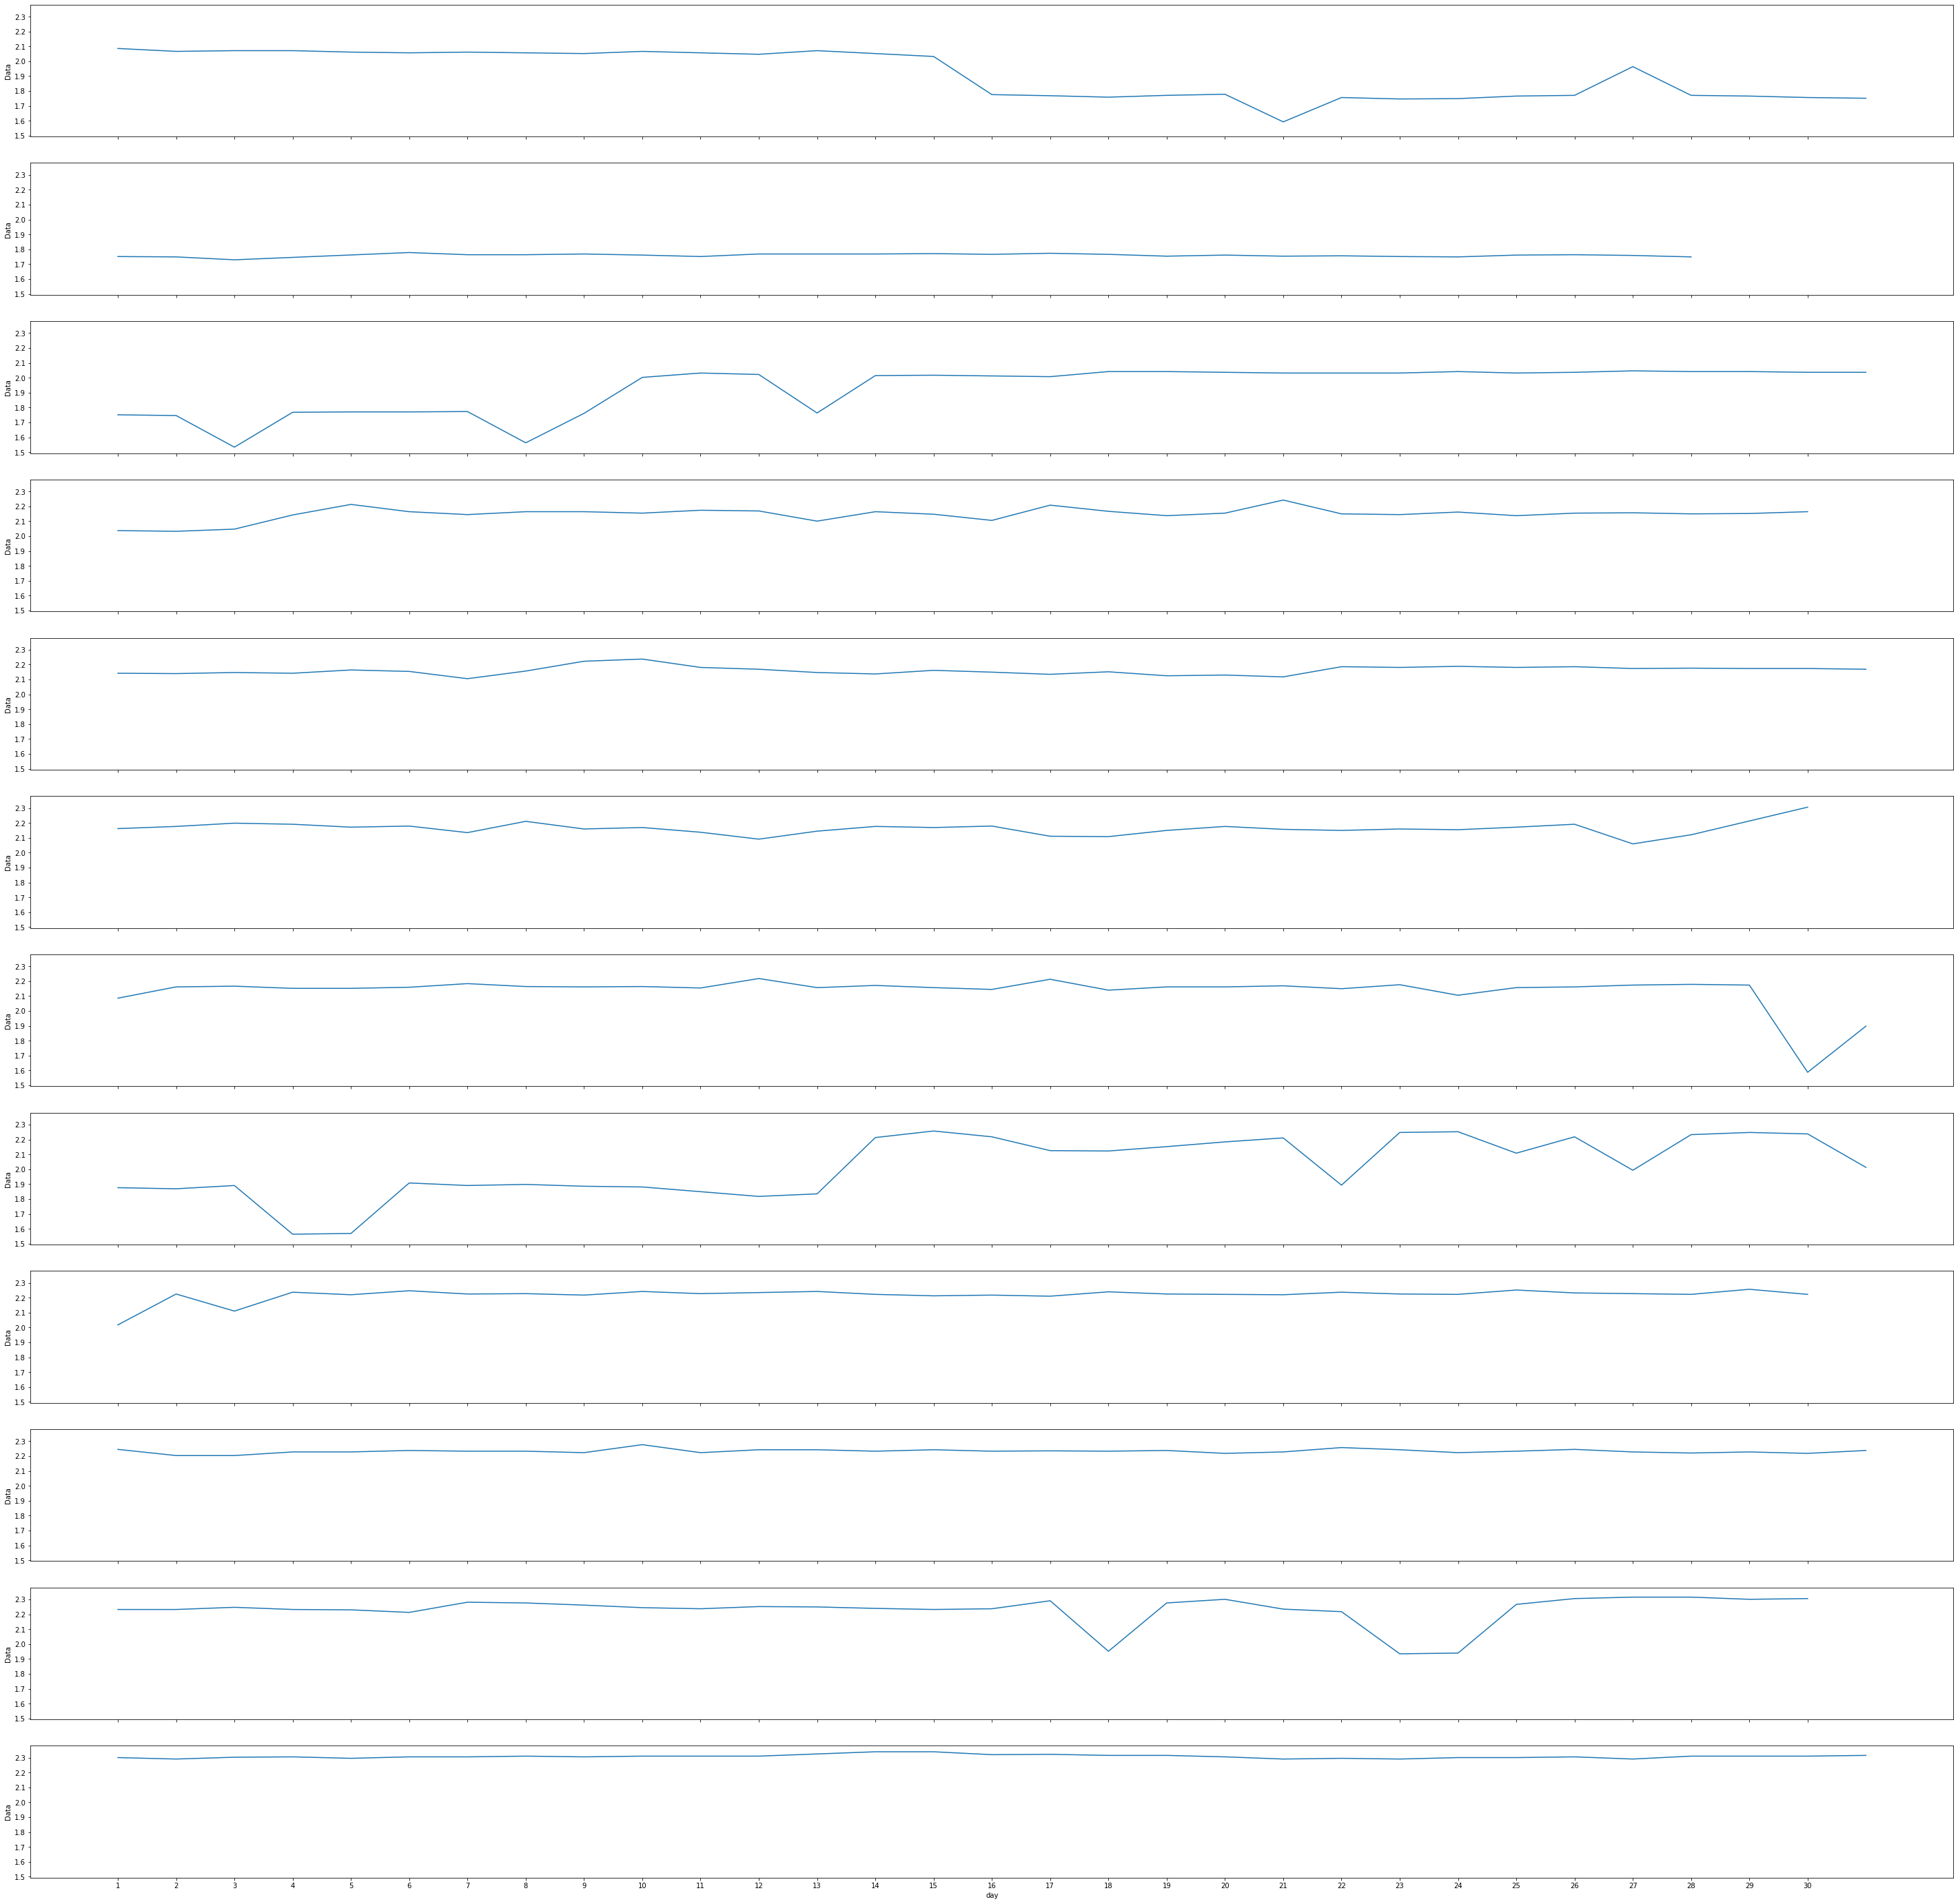

In [32]:
def plot_day_data_in_year(df, year):
  year_data = df[df['year'] == year]
  fig, axes = plt.subplots(12, 1, figsize=(50, 50), sharex=True, sharey=True)
  for month in range(1, 13):
    month_data = year_data[year_data['month'] == month][['day', 'Data']]
    daily_min = month_data.groupby('day').min()
    daily_max = month_data.groupby('day').max()
    daily_median = month_data.groupby('day').median()
    daily_variance = month_data.groupby('day').var()
    plot = sns.lineplot(ax=axes[month-1], data=daily_median, x='day', y='Data')
    plot.set_xticks(range(1,len(daily_median))) # <--- set the ticks first
    
plot_day_data_in_year(pressure_data['A04'], 2017)
# weather_data['MeteoCentral']

,r_squared,MSE
Jan,0.167718,0.020087
Feb,0.175665,0.000086
Mar,0.032799,0.022776
Apr,0.044167,0.001913
May,0.047149,0.000739
Jun,0.067721,0.001686
Jul,0.034722,0.012226
Aug,0.001071,0.038875
Sep,0.133315,0.001699
Oct,0.172582,0.000160


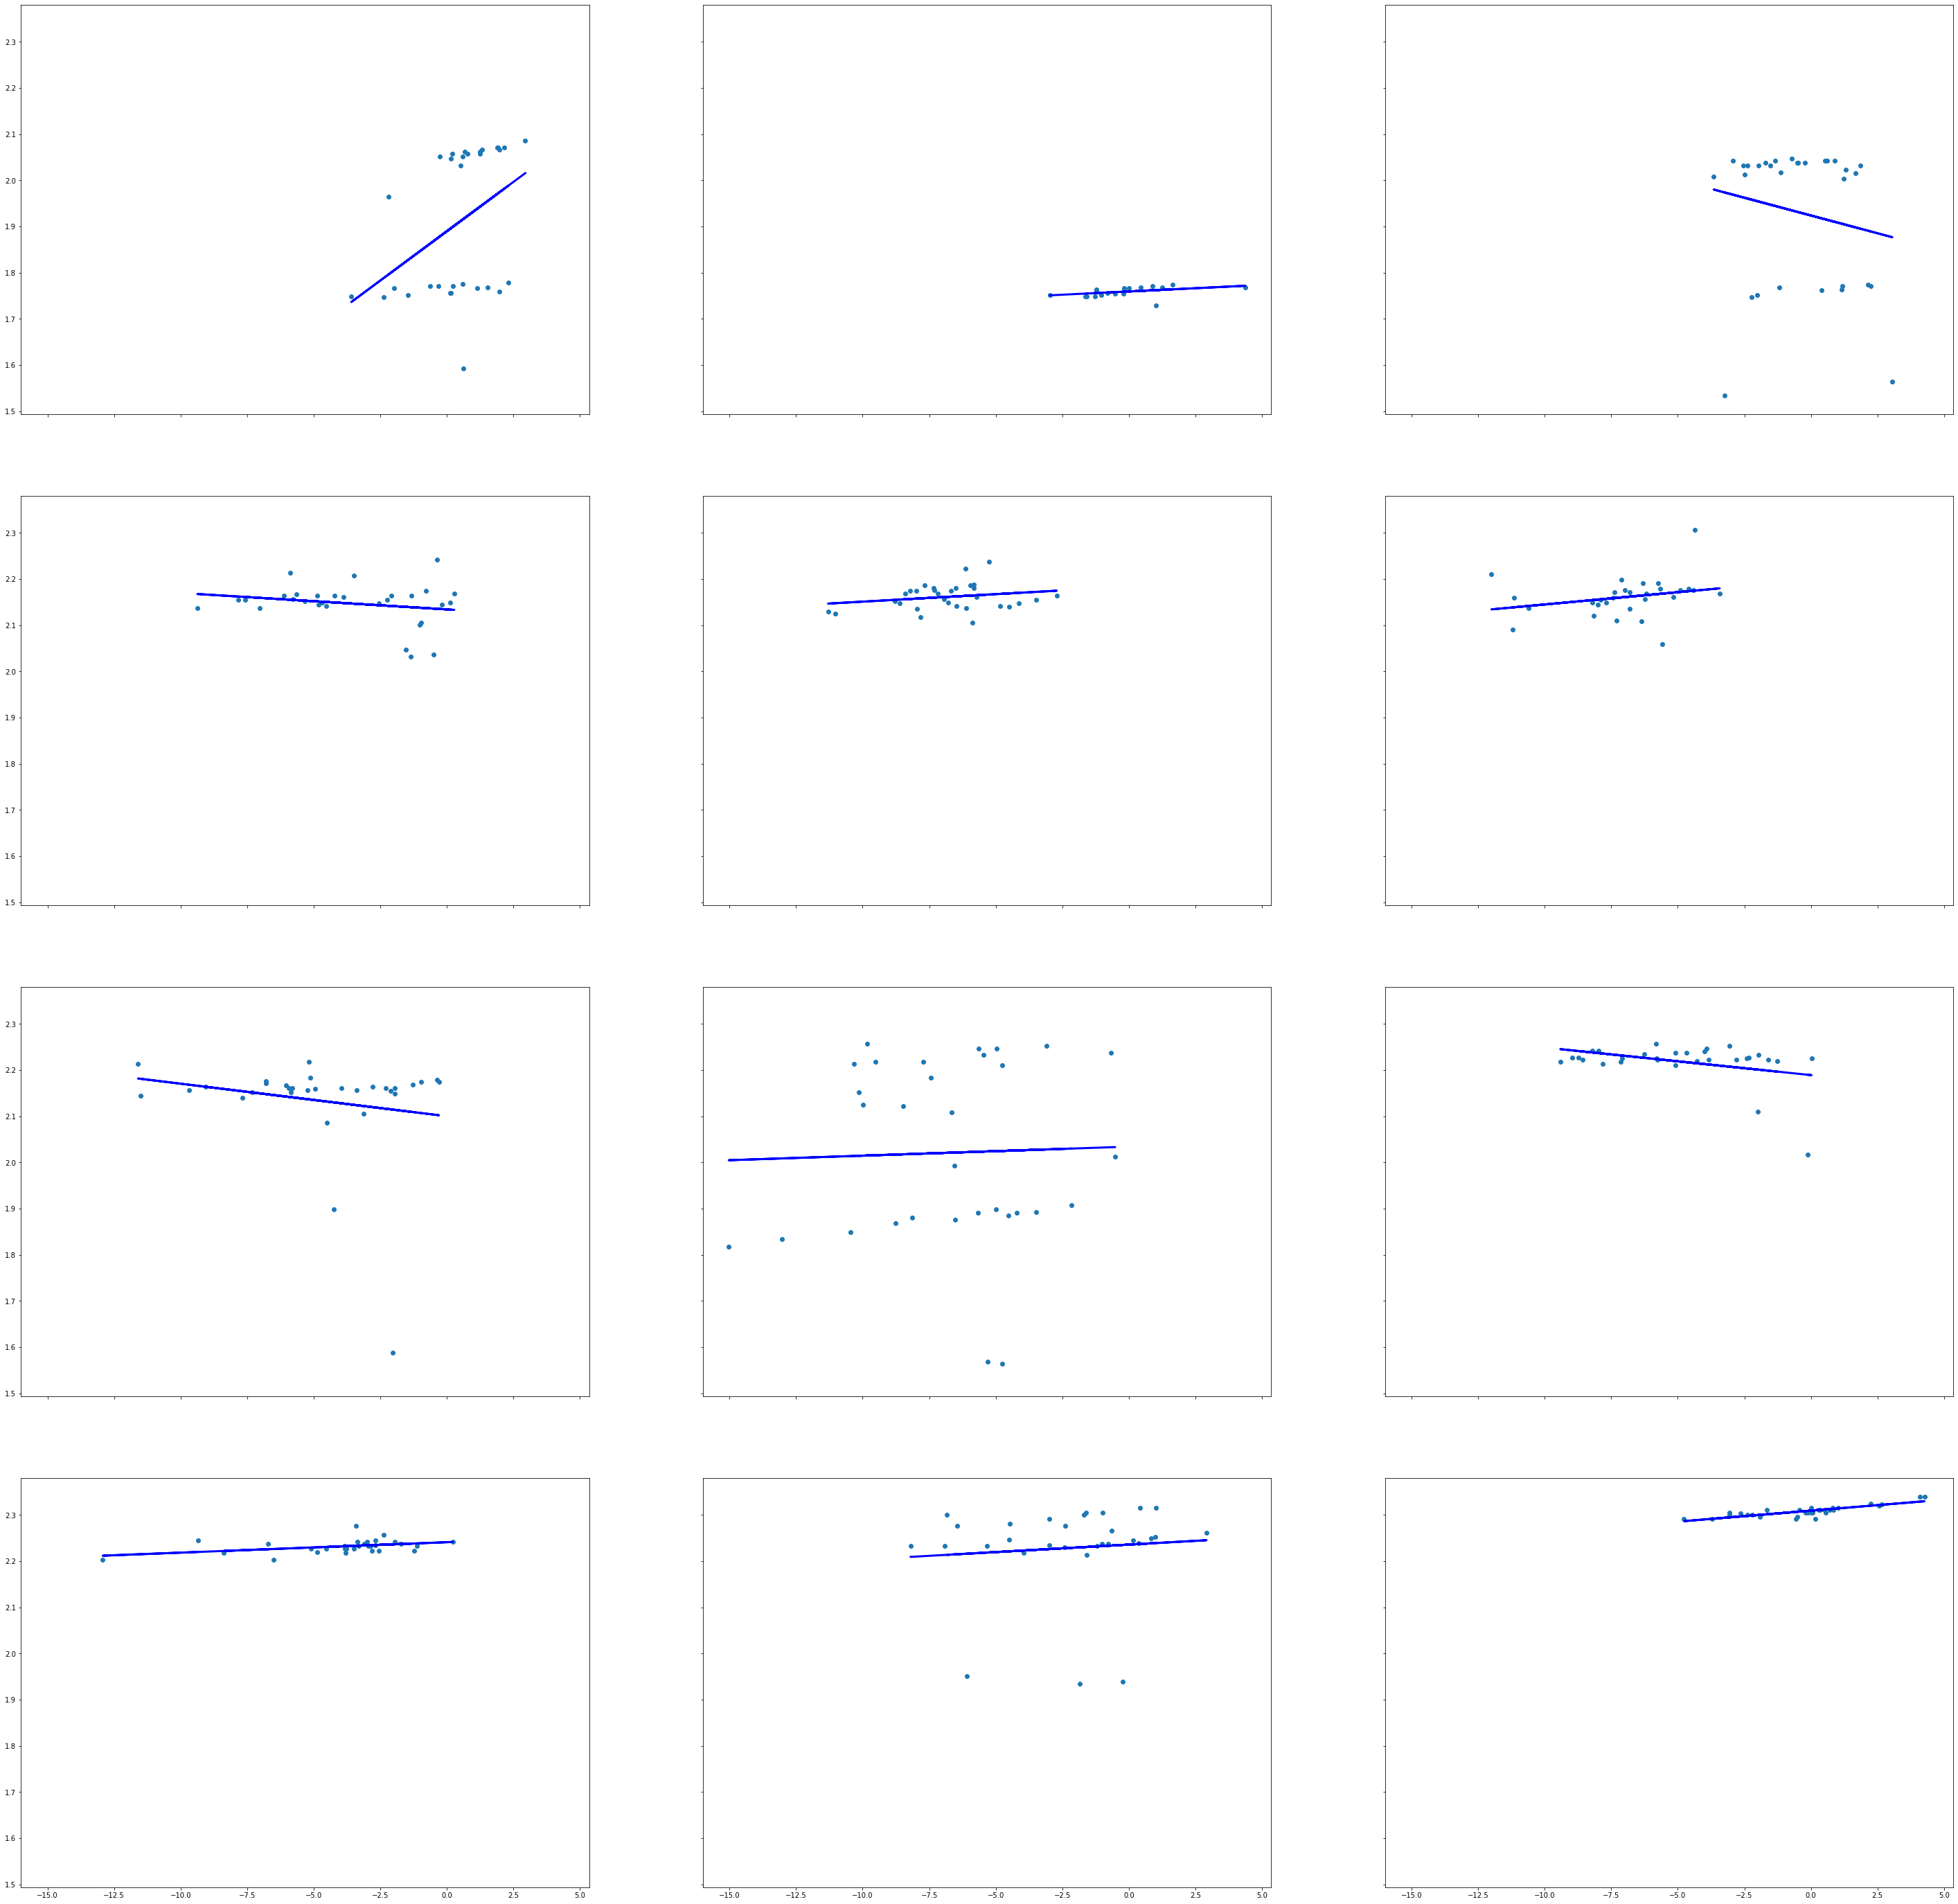

In [33]:
def scatter_day_data_in_year(pressure, weather, year):
  pressure_year_data = pressure[pressure['year'] == year]
  weather_year_data = weather[weather['year'] == year]
  fig, axes = plt.subplots(4, 3, figsize=(50, 50), sharex=True, sharey=True)
  r_2 = []
  MSE = []
  for month in range(1, 13):
    pressure_month_data = pressure_year_data[pressure_year_data['month'] == month][['day', 'Data']]
    weather_month_data = weather_year_data[weather_year_data['month'] == month][['day', 'Data']]
    # daily_min = month_data.groupby('day').min()
    # daily_max = month_data.groupby('day').max()
    # daily_median = month_data.groupby('day').median()
    pressure_daily_median = pressure_month_data.groupby('day').median()
    weather_daily_median = weather_month_data.groupby('day').median()
    pressure_daily_median = pressure_daily_median.rename(columns={"Data":"pressure"})
    weather_daily_median = weather_daily_median.rename(columns={"Data":"weather"})
    median_table = pd.concat([weather_daily_median, pressure_daily_median], axis=1)
    median_table = median_table.dropna()
    
    regr = linear_model.LinearRegression()
    regr.fit(median_table['weather'].to_numpy().reshape(-1,1), median_table['pressure'].to_numpy().reshape(-1,1))
    pressure_pred = regr.predict(median_table['weather'].to_numpy().reshape(-1,1))

    r_2.append(r2_score(median_table['pressure'].to_numpy().reshape(-1,1), pressure_pred))
    MSE.append(mean_squared_error(median_table['pressure'].to_numpy().reshape(-1,1), pressure_pred))

    axes[(month-1)//3, (month-1)%3].scatter(data=median_table, x='weather', y='pressure')
    axes[(month-1)//3, (month-1)%3].plot(median_table['weather'], pressure_pred, color="blue", linewidth=3)

  metrics = pd.DataFrame(list(zip(r_2, MSE)),columns =['r_squared', 'MSE'], \
                         index =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
  return metrics

scatter_day_data_in_year(pressure_data['A04'], weather_data['MeteoCentral'], 2017)
# weather_data['MeteoCentral']


,r_squared,MSE
Jan,0.163525,0.020188
Feb,0.664003,0.000035
Mar,0.048444,0.022408
Apr,0.056360,0.001889
May,0.024088,0.000757
Jun,0.008445,0.001793
Jul,0.046159,0.012082
Aug,0.000695,0.038890
Sep,0.142727,0.001681
Oct,0.168379,0.000161


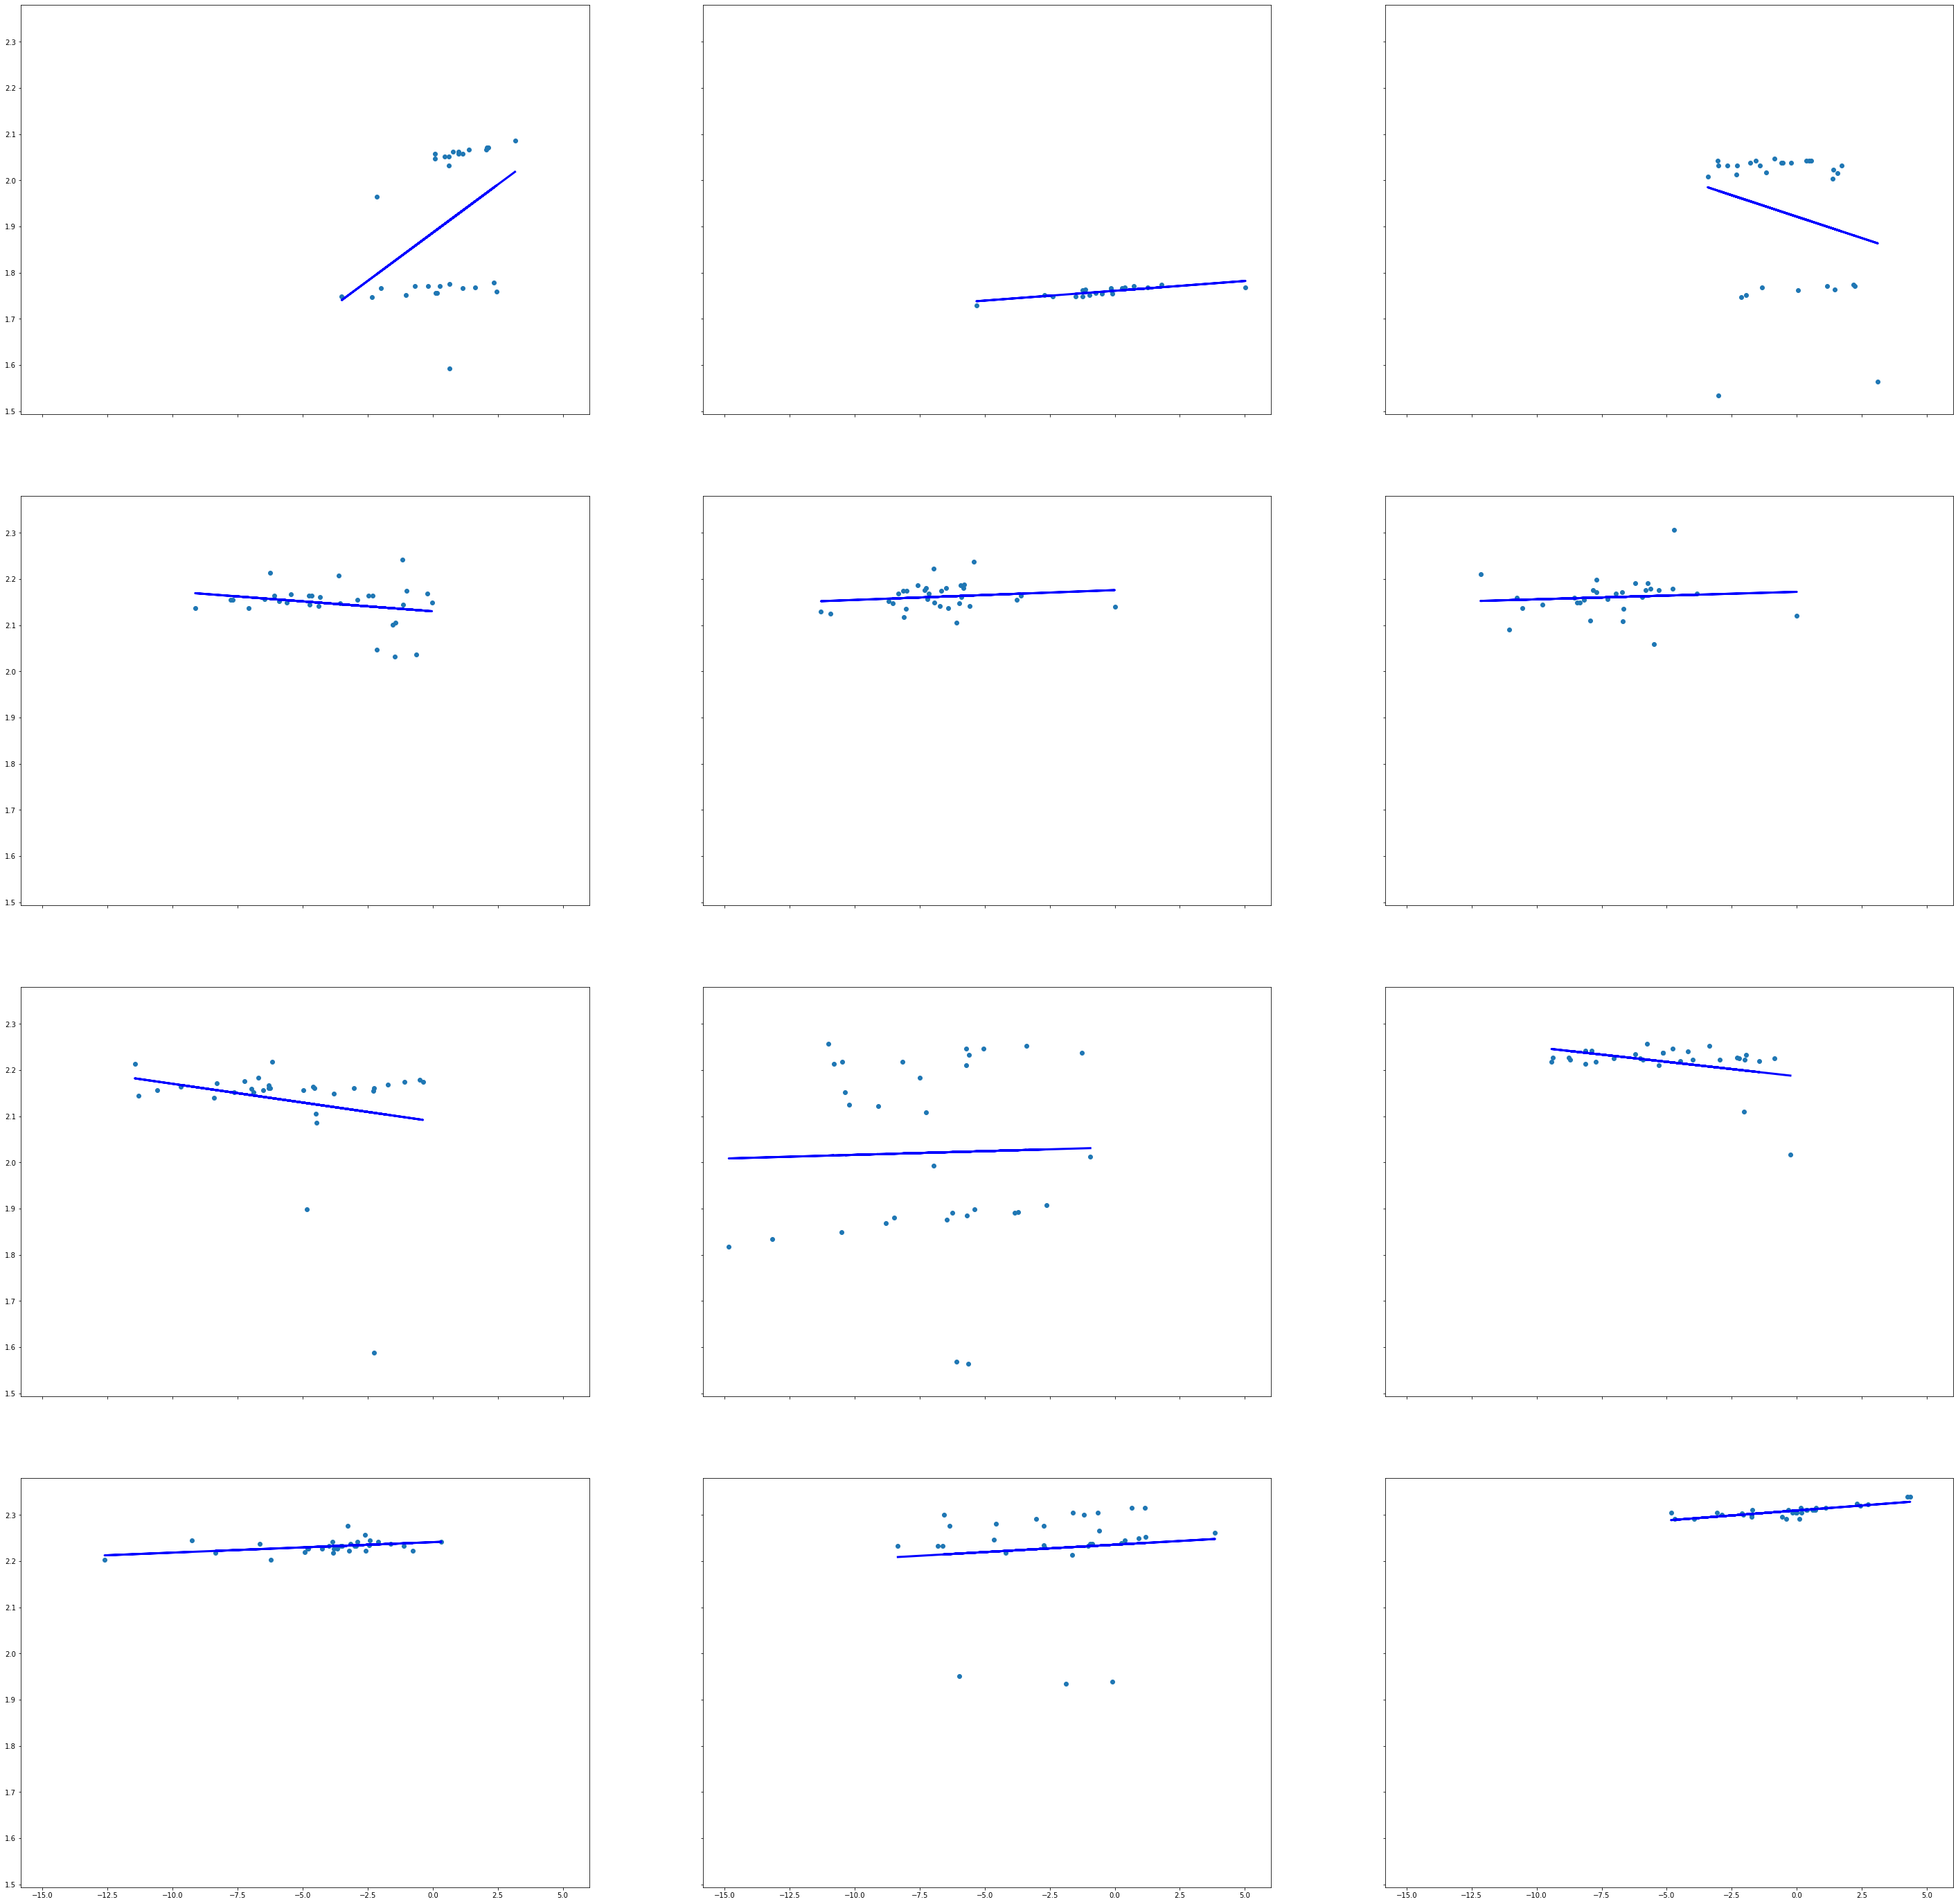

In [34]:
scatter_day_data_in_year(pressure_data['A04'], weather_data['MeteoTB2'], 2017)

## Linear model

In [35]:
df = pressure_data['A01'][['Data']]
column_indices = {name: i for i, name in enumerate(df.columns)}
df.reset_index()
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [36]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [37]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [38]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [39]:
def plot(self, model=None, plot_col='Data', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [40]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [41]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [42]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Data'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Data']

Using Facebook Prophet Time Series package

In [43]:
from prophet import Prophet

In [44]:
def change_columns(df):
  df['ds'] = df['Date']
  df['y'] = df['Data']
  return df

In [45]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
  m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
              seasonality_mode = 'additive',
              interval_width = interval_width,
              changepoint_range = changepoint_range)
  m = m.fit(dataframe)
  forecast = m.predict(dataframe)
  forecast['fact'] = dataframe['Data'].reset_index(drop = True)
  return forecast
  
df = change_columns(pressure_data['A01'])
pred = fit_predict_model(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmph2orzrbc/b_9_fe0i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph2orzrbc/zxhz2m1w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58138', 'data', 'file=/tmp/tmph2orzrbc/b_9_fe0i.json', 'init=/tmp/tmph2orzrbc/zxhz2m1w.json', 'output', 'file=/tmp/tmph2orzrbc/prophet_modelu9g65ebr/prophet_model-20221022182438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [46]:
def detect_anomalies(forecast):
  forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
  forecasted['anomaly'] = 0
  forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
  forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
  #anomaly importances
  forecasted['importance'] = 0
  forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
    (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
  forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
    (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
  forecasted['anomaly'] = forecasted['anomaly'].astype('category')
  return forecasted
  
pred = detect_anomalies(pred)

In [47]:
def prophet_pipeline(location):
  df = change_columns(pressure_data[location])
  pred = fit_predict_model(df)
  return detect_anomalies(pred)
pred = prophet_pipeline('A01')

DEBUG:cmdstanpy:input tempfile: /tmp/tmph2orzrbc/ughn569c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph2orzrbc/ungqz5m4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3057', 'data', 'file=/tmp/tmph2orzrbc/ughn569c.json', 'init=/tmp/tmph2orzrbc/ungqz5m4.json', 'output', 'file=/tmp/tmph2orzrbc/prophet_model0q92yohb/prophet_model-20221022182736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:27:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


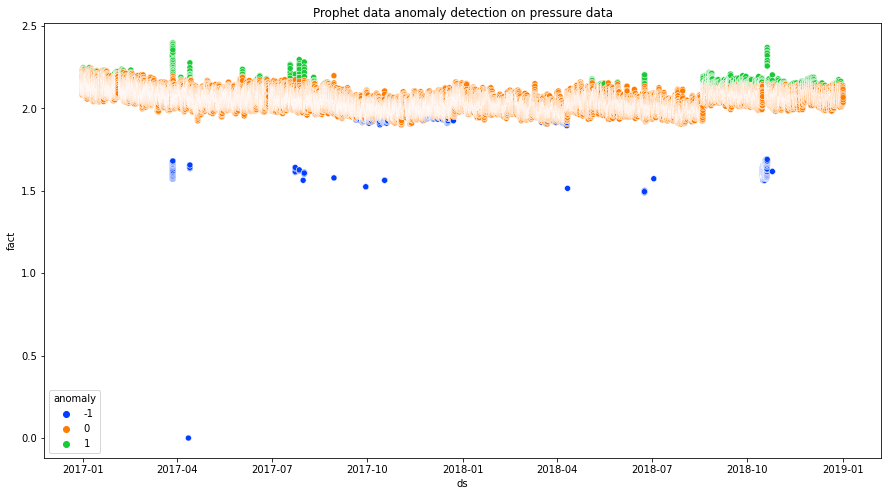

In [48]:
sns.set_palette("bright")
plt.figure(figsize=(15,8))
plt.title("Prophet data anomaly detection on pressure data")
sns.scatterplot(data=pred, x='ds', y = 'fact', hue='anomaly')
# sample output below:
# green represents abnormally high values 
# blue represents abnormally low values

In [49]:
A01 = pressure_data['A01']
A01

,Date,Data,day,month,year,hour,minute,second,ds,y
0,2016-12-31 00:00:27.228,2.085938,31,12,2016,0,0,27,2016-12-31 00:00:27.228,2.085938
1,2016-12-31 00:10:27.228,2.085938,31,12,2016,0,10,27,2016-12-31 00:10:27.228,2.085938
2,2016-12-31 00:20:27.228,2.100586,31,12,2016,0,20,27,2016-12-31 00:20:27.228,2.100586
3,2016-12-31 00:30:27.228,2.125000,31,12,2016,0,30,27,2016-12-31 00:30:27.228,2.125000
4,2016-12-31 00:40:27.228,2.129883,31,12,2016,0,40,27,2016-12-31 00:40:27.228,2.129883
...,...,...,...,...,...,...,...,...,...,...
47110,2017-12-31 23:12:04.512,2.032227,31,12,2017,23,12,4,2017-12-31 23:12:04.512,2.032227
47111,2017-12-31 23:22:04.512,2.037109,31,12,2017,23,22,4,2017-12-31 23:22:04.512,2.037109
47112,2017-12-31 23:32:04.512,2.051758,31,12,2017,23,32,4,2017-12-31 23:32:04.512,2.051758
47113,2017-12-31 23:42:04.512,2.076172,31,12,2017,23,42,4,2017-12-31 23:42:04.512,2.076172


In [50]:
A01['Date'] = pd.to_datetime(A01['Date'])
A01

,Date,Data,day,month,year,hour,minute,second,ds,y
0,2016-12-31 00:00:27.228,2.085938,31,12,2016,0,0,27,2016-12-31 00:00:27.228,2.085938
1,2016-12-31 00:10:27.228,2.085938,31,12,2016,0,10,27,2016-12-31 00:10:27.228,2.085938
2,2016-12-31 00:20:27.228,2.100586,31,12,2016,0,20,27,2016-12-31 00:20:27.228,2.100586
3,2016-12-31 00:30:27.228,2.125000,31,12,2016,0,30,27,2016-12-31 00:30:27.228,2.125000
4,2016-12-31 00:40:27.228,2.129883,31,12,2016,0,40,27,2016-12-31 00:40:27.228,2.129883
...,...,...,...,...,...,...,...,...,...,...
47110,2017-12-31 23:12:04.512,2.032227,31,12,2017,23,12,4,2017-12-31 23:12:04.512,2.032227
47111,2017-12-31 23:22:04.512,2.037109,31,12,2017,23,22,4,2017-12-31 23:22:04.512,2.037109
47112,2017-12-31 23:32:04.512,2.051758,31,12,2017,23,32,4,2017-12-31 23:32:04.512,2.051758
47113,2017-12-31 23:42:04.512,2.076172,31,12,2017,23,42,4,2017-12-31 23:42:04.512,2.076172


## Data Proprocessing

resampling the data hourly. By keeping timestamp as an index, we are resampling it on an hourly basis from half an hour and taking its mean. It will not disturb the data distribution because it takes 2 values and finds its mean.

In [51]:
A01= A01.set_index('Date').resample('H').mean().reset_index()
A01

,Date,Data,day,month,year,hour,minute,second,y
0,2016-12-31 00:00:00,2.075765,31.0,12.0,2016.0,0.0,29.500000,41.5,2.075765
1,2016-12-31 01:00:00,2.069661,31.0,12.0,2016.0,1.0,29.500000,41.5,2.069661
2,2016-12-31 02:00:00,2.084717,31.0,12.0,2016.0,2.0,29.500000,41.5,2.084717
3,2016-12-31 03:00:00,2.098145,31.0,12.0,2016.0,3.0,29.500000,41.5,2.098145
4,2016-12-31 04:00:00,2.074544,31.0,12.0,2016.0,4.0,29.500000,41.5,2.074544
...,...,...,...,...,...,...,...,...,...
17539,2018-12-31 19:00:00,2.056641,31.0,12.0,2018.0,19.0,39.000000,36.5,2.056641
17540,2018-12-31 20:00:00,2.049316,31.0,12.0,2018.0,20.0,34.000000,36.0,2.049316
17541,2018-12-31 21:00:00,2.000488,31.0,12.0,2018.0,21.0,36.500000,36.0,2.000488
17542,2018-12-31 22:00:00,2.028971,31.0,12.0,2018.0,22.0,32.333333,36.0,2.028971


## Data Visualization

Now we are going to plot the data, and I am drawing the line chart. On the x-axis, we have a timestamp, and on Y-axis, we have values.

In [52]:
fig = px.line(A01.reset_index(), x='Date', y='Data')

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='2y', step="year", stepmode="backward"),
              dict(count=3, label='3y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

In [53]:
A01 = change_columns(A01)
A01

,Date,Data,day,month,year,hour,minute,second,y,ds
0,2016-12-31 00:00:00,2.075765,31.0,12.0,2016.0,0.0,29.500000,41.5,2.075765,2016-12-31 00:00:00
1,2016-12-31 01:00:00,2.069661,31.0,12.0,2016.0,1.0,29.500000,41.5,2.069661,2016-12-31 01:00:00
2,2016-12-31 02:00:00,2.084717,31.0,12.0,2016.0,2.0,29.500000,41.5,2.084717,2016-12-31 02:00:00
3,2016-12-31 03:00:00,2.098145,31.0,12.0,2016.0,3.0,29.500000,41.5,2.098145,2016-12-31 03:00:00
4,2016-12-31 04:00:00,2.074544,31.0,12.0,2016.0,4.0,29.500000,41.5,2.074544,2016-12-31 04:00:00
...,...,...,...,...,...,...,...,...,...,...
17539,2018-12-31 19:00:00,2.056641,31.0,12.0,2018.0,19.0,39.000000,36.5,2.056641,2018-12-31 19:00:00
17540,2018-12-31 20:00:00,2.049316,31.0,12.0,2018.0,20.0,34.000000,36.0,2.049316,2018-12-31 20:00:00
17541,2018-12-31 21:00:00,2.000488,31.0,12.0,2018.0,21.0,36.500000,36.0,2.000488,2018-12-31 21:00:00
17542,2018-12-31 22:00:00,2.028971,31.0,12.0,2018.0,22.0,32.333333,36.0,2.028971,2018-12-31 22:00:00


#### Seperate the train and test set 

In [54]:
train = A01[(A01['ds'] >= '2016-12-31') & (A01['ds'] <= '2017-12-31')]
test = A01[(A01['ds'] > '2017-12-31')]

In [55]:
model = Prophet(changepoint_range=0.95)
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph2orzrbc/1s79p95d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph2orzrbc/jrn96j5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29370', 'data', 'file=/tmp/tmph2orzrbc/1s79p95d.json', 'init=/tmp/tmph2orzrbc/jrn96j5l.json', 'output', 'file=/tmp/tmph2orzrbc/prophet_modeltmy532gk/prophet_model-20221022183033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Forecast on test data

In [56]:
future = model.make_future_dataframe(periods=119, freq='H')

In [57]:
forecast = model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8875,2018-01-04 19:00:00,2.101438,2.050589,2.155528
8876,2018-01-04 20:00:00,2.092102,2.038907,2.139857
8877,2018-01-04 21:00:00,2.079620,2.023874,2.133007
8878,2018-01-04 22:00:00,2.067781,2.016547,2.120181
8879,2018-01-04 23:00:00,2.059895,2.006888,2.112634


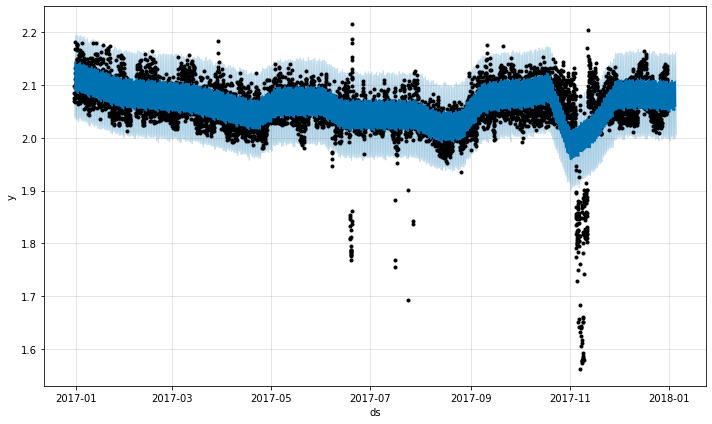

In [58]:
result = pd.concat([A01.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = model.plot(forecast)

###The top one is a trend.
### The second plot shows the weekly trend
### The third plot is about the daily pattern which shows the 24 hours window

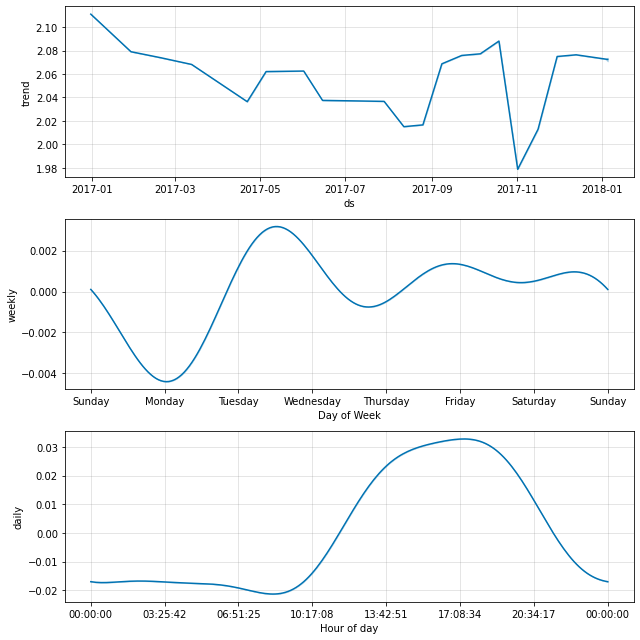

In [59]:
comp = model.plot_components(forecast)

## Anomaly and outlier detection

The error can be negative or positive so we are taking absolute of it and checking that is it greater than the uncertainty level then most probably it is an outlier or an incident that is most likely to outperform in a dataset from a normal distribution. And these points or records we will get it will be assigned as an anomaly in the data.

In [60]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [61]:
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
#result['anomaly'] = np.where(np.abs(x['error']) > 1.5*x['uncertainty']), 'Yes', 'No') #Alternate way

In [62]:
#visualize the anomaly data
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly')
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='3y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

# Isolation Forest

In [63]:
from sklearn.ensemble import IsolationForest
central_weather = weather_data['MeteoCentral']
central_weather.rename(columns = {'Data':'temp'}, inplace = True)
central_weather['datetime'] = central_weather['Date'].dt.date
weather_train = central_weather.groupby('datetime').mean()
df = pressure_data['A07']
df['datetime'] = df['Date'].dt.date
pressure_train = df.groupby('datetime').mean()
pressure_train.rename(columns = {'Data':'pressure'}, inplace = True)

In [64]:
merged_df = pd.merge(pressure_train, weather_train,  how='left', left_on=['datetime'], right_on = ['datetime'])
merged_df = merged_df.dropna()

In [65]:
from sklearn.ensemble import IsolationForest
train_data = merged_df[['pressure','temp']]
ifm = IsolationForest(contamination=0.04)
ifm.fit(train_data)
y_pred_train = ifm.predict(train_data)

In [66]:
import plotly.express as px
train_data['outliers']=y_pred_train
fig = px.scatter(train_data, x='pressure', y='temp', color='outliers', title='pressure')

fig.show()